# 1. Create Datasets

In [1]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np

class SegmentationDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_folder = os.path.join(folder_path, 'image')
        self.mask_folder = os.path.join(folder_path, 'mask')

        self.image_paths = os.listdir(self.image_folder)
        self.mask_paths = os.listdir(self.mask_folder)

        self.data_count = len(self.image_paths)

    def __len__(self):
        return self.data_count

    @staticmethod
    def read_image(path):
        return np.array(Image.open(path).convert('L'))
    
    def __getitem__(self, index):
        image = self.read_image(os.path.join(self.image_folder, self.image_paths[index]))
        mask = self.read_image(os.path.join(self.mask_folder, self.mask_paths[index]))
        
        if self.transform:
            result = self.transform(image=image, mask=mask)

            image = result["image"]
            mask = result["mask"].squeeze()

            return image, mask
        else:
            return image, mask


In [2]:
mean = 125.46322137691357 / 255
std = 32.4722533092388 / 255

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

size = 128
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),

    A.GaussNoise(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Blur(p=0.1),

    A.Resize(size, size),
    A.Normalize(mean=(mean,), std=(std,), max_pixel_value=255),

    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(size, size),
    A.Normalize(mean=(mean,), std=(std,)),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(size, size),
    A.Normalize(mean=(mean,), std=(std,)),
    ToTensorV2()
])

c:\Users\can.michael\AppData\Local\anaconda3\envs\torchenv\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
import os 

data_path = r'data_split'

train_path = os.path.join(data_path, 'train')
train_dataset = SegmentationDataset(train_path, transform=train_transform)

val_path = os.path.join(data_path, 'val')
val_dataset = SegmentationDataset(val_path, transform=val_transform)


test_path = os.path.join(data_path, 'test')
test_dataset = SegmentationDataset(test_path, transform=test_transform)

print(f"Dataset sizes: Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Dataset sizes: Train: 4500, Val: 450, Test: 450


## 1.1. Visualize Dataset

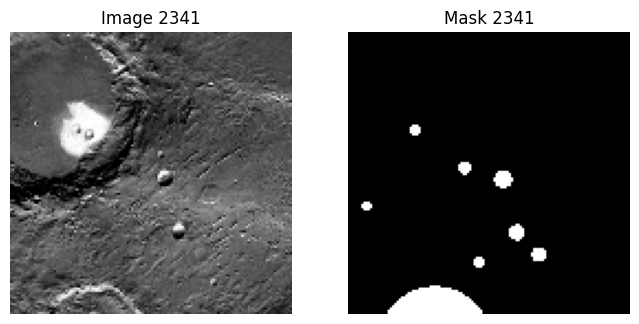

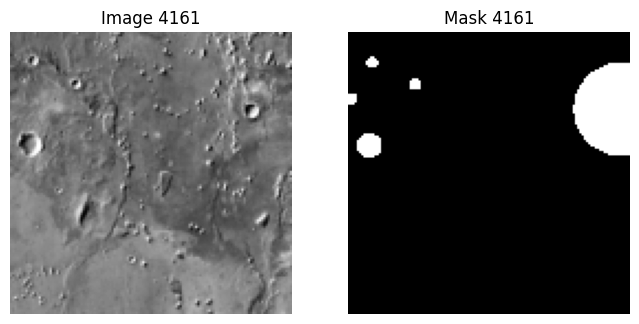

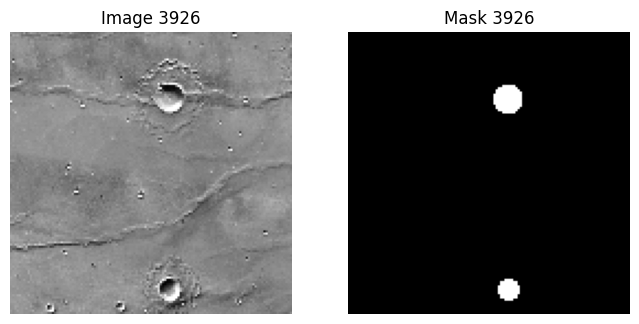

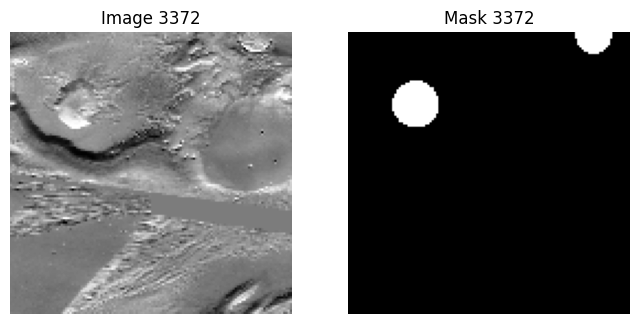

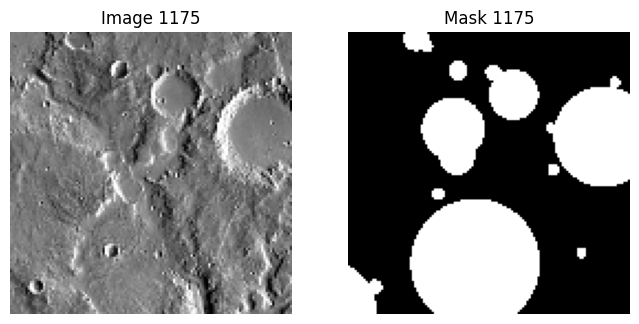

In [5]:
from matplotlib import pyplot as plt

def show_image_mask(image, mask, idx):
    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'Image {idx}')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title(f'Mask {idx}')

    plt.show()

for i in range(5):
    random_idx = np.random.randint(0, len(train_dataset))
    image, mask = train_dataset[random_idx]
    show_image_mask(image, mask, random_idx)

# 2. Creating Model

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 2.2. Define Model

In [7]:
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="timm-resnest200e",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
    activation="sigmoid"
).to(device)     

## 2.3. Getting Summary of Model

In [8]:
from torchinfo import summary

summary(model, input_size=(1, 1, size, size))

Layer (type:depth-idx)                        Output Shape              Param #
UnetPlusPlus                                  [1, 1, 128, 128]          --
├─ResNestEncoder: 1-1                         [1, 1, 128, 128]          --
│    └─Sequential: 2-1                        [1, 128, 64, 64]          --
│    │    └─Conv2d: 3-1                       [1, 64, 64, 64]           576
│    │    └─BatchNorm2d: 3-2                  [1, 64, 64, 64]           128
│    │    └─ReLU: 3-3                         [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-4                       [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-5                  [1, 64, 64, 64]           128
│    │    └─ReLU: 3-6                         [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-7                       [1, 128, 64, 64]          73,728
│    └─BatchNorm2d: 2-2                       [1, 128, 64, 64]          256
│    └─ReLU: 2-3                              [1, 128, 64, 64]          --
│    └─M

# 3. Training

## 3.1. Metrics

In [9]:
from torchmetrics.classification import BinaryJaccardIndex
from torchmetrics.classification import BinaryPrecision
from torchmetrics.classification import BinaryRecall
from torchmetrics.classification import BinaryF1Score
from torchmetrics.classification import BinaryAccuracy

calculate_iou = BinaryJaccardIndex().to(device)
calculate_precision = BinaryPrecision().to(device)
calculate_recall = BinaryRecall().to(device)
calculate_f1 = BinaryF1Score().to(device)
calculate_accuracy = BinaryAccuracy().to(device)

def calculate_metrics(predictions, targets):
    predictions = (predictions > 0.4).float()
    iou = calculate_iou(predictions, targets)
    precision = calculate_precision(predictions, targets)
    recall = calculate_recall(predictions, targets)
    f1 = calculate_f1(predictions, targets)
    accuracy = calculate_accuracy(predictions, targets)

    return iou, precision, recall, f1, accuracy

## 3.2. Training Loop

In [10]:
from tqdm import tqdm

progress_bar = None

In [11]:
def train_step(model, train_loader, loss_fn, optimizer):
    global progress_bar
    model.train()
    train_loss = 0.0
    train_iou = 0.0
    train_precision = 0.0
    train_recall = 0.0
    train_f1 = 0.0
    train_accuracy = 0.0

    progress_bar = tqdm(total=len(train_loader), desc="Training", leave=False)

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(images).squeeze(1)
        loss = loss_fn(outputs, labels.float())

        loss.backward()
        optimizer.step()

        iou, precision, recall, f1, accuracy = calculate_metrics(outputs, labels)

        train_loss += loss.item()
        train_iou += iou.item()
        train_precision += precision.item()
        train_recall += recall.item()
        train_f1 += f1.item()
        train_accuracy += accuracy.item()

        progress_bar.update(1)
        progress_bar.set_postfix({"Loss": loss.item(), "IoU": iou.item(), "F1": f1.item()})
        
    progress_bar.close()

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)
    train_precision /= len(train_loader)
    train_recall /= len(train_loader)
    train_f1 /= len(train_loader)
    train_accuracy /= len(train_loader)

    return train_loss, train_iou, train_precision, train_recall, train_f1, train_accuracy

In [12]:
def val_step(model, val_loader, loss_fn):
    global progress_bar
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_precision = 0.0
    val_recall = 0.0
    val_f1 = 0.0
    val_accuracy = 0.0
    
    progress_bar = tqdm(total=len(val_loader), desc="Validation", leave=False)

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images).squeeze(1)
            loss = loss_fn(outputs, labels.float())
            iou, precision, recall, f1, accuracy = calculate_metrics(outputs, labels)

            val_loss += loss.item()
            val_iou += iou.item()
            val_precision += precision.item()
            val_recall += recall.item()
            val_f1 += f1.item()
            val_accuracy += accuracy.item()

            progress_bar.update(1)
            progress_bar.set_postfix({"Loss": loss.item(), "IoU": iou.item(), "F1": f1.item()})
            
    progress_bar.close()

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)
    val_precision /= len(val_loader)
    val_recall /= len(val_loader)
    val_f1 /= len(val_loader)
    val_accuracy /= len(val_loader)

    return val_loss, val_iou, val_precision, val_recall, val_f1, val_accuracy

In [13]:
def update_result_dict(result_dict, train_loss, train_iou, train_precision, train_recall, train_f1, train_accuracy, val_loss, val_iou, val_precision, val_recall, val_f1, val_accuracy):
    result_dict['train_loss'].append(train_loss)
    result_dict['train_iou'].append(train_iou)
    result_dict['train_precision'].append(train_precision)
    result_dict['train_recall'].append(train_recall)
    result_dict['train_f1'].append(train_f1)
    result_dict['train_accuracy'].append(train_accuracy)

    result_dict['val_loss'].append(val_loss)
    result_dict['val_iou'].append(val_iou)
    result_dict['val_precision'].append(val_precision)
    result_dict['val_recall'].append(val_recall)
    result_dict['val_f1'].append(val_f1)
    result_dict['val_accuracy'].append(val_accuracy)

In [14]:
def train(model, train_loader, val_loader, loss_fn, optimizer, epochs, best_model_path, result_dict):
  best_fscore = 0.0

  for epoch in range(epochs):
    train_loss, train_iou, train_precision, train_recall, train_f1, train_accuracy = train_step(model, train_loader, loss_fn, optimizer)
    print(f"Epoch {epoch + 1} | Train Loss: {train_loss:.5f} | Train IoU: {train_iou:.5f} | Train Precision: {train_precision:.5f} | Train Recall: {train_recall:.5f} | Train F1: {train_f1:.5f} | Train Accuracy: {train_accuracy:.5f}")

    val_loss, val_iou, val_precision, val_recall, val_f1, val_accuracy = val_step(model, val_loader, loss_fn)
    print(f"Epoch {epoch + 1} | Val Loss: {val_loss:.5f} | Val IoU: {val_iou:.5f} | Val Precision: {val_precision:.5f} | Val Recall: {val_recall:.5f} | Val F1: {val_f1:.5f} | Val Accuracy: {val_accuracy:.5f}")

    update_result_dict(result_dict, train_loss, train_iou, train_precision, train_recall, train_f1, train_accuracy, val_loss, val_iou, val_precision, val_recall, val_f1, val_accuracy)

    if val_f1 > best_fscore:
      best_fscore = val_f1
      torch.save(model, best_model_path)
      print(f"Model saved at {best_model_path} with F1 score: {100*best_fscore:.2f}%")

In [15]:
result_dict = {
    'train_loss': [],
    'train_iou': [],
    'train_precision': [],
    'train_recall': [],
    'train_f1': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_iou': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': [],
    'val_accuracy': []
}

In [16]:
from datetime import datetime

BATCH_SIZE = 8
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 100
best_model_path = f'unetplusplus_timmresnest200e_bce_adam_lr1e4_bs{BATCH_SIZE}_softaug_04.pth-{datetime.now().strftime("%Y_%m_%d")}'

best_model_path

'unetplusplus_timmresnest200e_bce_adam_lr1e4_bs8_softaug_04.pth-2024_12_28'

In [17]:
train(model, train_loader, val_loader, loss_fn, optimizer, epochs, best_model_path, result_dict)

Epoch 1 | Train Loss: 0.25550 | Train IoU: 0.45804 | Train Precision: 0.63661 | Train Recall: 0.66618 | Train F1: 0.61151 | Train Accuracy: 0.90896


Epoch 1 | Val Loss: 0.10995 | Val IoU: 0.49051 | Val Precision: 0.77997 | Val Recall: 0.58461 | Val F1: 0.63997 | Val Accuracy: 0.97782
Model saved at unetplusplus_timmresnest200e_bce_adam_lr1e4_bs8_softaug_04.pth-2024_12_28 with F1 score: 64.00%


Epoch 2 | Train Loss: 0.14785 | Train IoU: 0.55285 | Train Precision: 0.78168 | Train Recall: 0.66416 | Train F1: 0.70429 | Train Accuracy: 0.95309


Epoch 2 | Val Loss: 0.08067 | Val IoU: 0.51317 | Val Precision: 0.75938 | Val Recall: 0.63865 | Val F1: 0.65909 | Val Accuracy: 0.97792
Model saved at unetplusplus_timmresnest200e_bce_adam_lr1e4_bs8_softaug_04.pth-2024_12_28 with F1 score: 65.91%


Epoch 3 | Train Loss: 0.13079 | Train IoU: 0.59069 | Train Precision: 0.81596 | Train Recall: 0.68727 | Train F1: 0.73498 | Train Accuracy: 0.95860


Epoch 3 | Val Loss: 0.07772 | Val IoU: 0.52227 | Val Precision: 0.77772 | Val Recall: 0.63362 | Val F1: 0.66745 | Val Accuracy: 0.97838
Model saved at unetplusplus_timmresnest200e_bce_adam_lr1e4_bs8_softaug_04.pth-2024_12_28 with F1 score: 66.74%


Epoch 4 | Train Loss: 0.12568 | Train IoU: 0.59510 | Train Precision: 0.82190 | Train Recall: 0.68845 | Train F1: 0.73859 | Train Accuracy: 0.95944


Epoch 4 | Val Loss: 0.07374 | Val IoU: 0.53753 | Val Precision: 0.77542 | Val Recall: 0.65000 | Val F1: 0.68261 | Val Accuracy: 0.97942
Model saved at unetplusplus_timmresnest200e_bce_adam_lr1e4_bs8_softaug_04.pth-2024_12_28 with F1 score: 68.26%


Epoch 5 | Train Loss: 0.11585 | Train IoU: 0.62898 | Train Precision: 0.83839 | Train Recall: 0.71975 | Train F1: 0.76627 | Train Accuracy: 0.96306


Epoch 5 | Val Loss: 0.11236 | Val IoU: 0.43071 | Val Precision: 0.55140 | Val Recall: 0.69054 | Val F1: 0.56059 | Val Accuracy: 0.95057


Epoch 6 | Train Loss: 0.11333 | Train IoU: 0.63429 | Train Precision: 0.83935 | Train Recall: 0.72594 | Train F1: 0.76989 | Train Accuracy: 0.96345


Epoch 6 | Val Loss: 0.06864 | Val IoU: 0.53961 | Val Precision: 0.81973 | Val Recall: 0.62532 | Val F1: 0.67946 | Val Accuracy: 0.98141


Epoch 7 | Train Loss: 0.10864 | Train IoU: 0.64673 | Train Precision: 0.84796 | Train Recall: 0.73510 | Train F1: 0.77903 | Train Accuracy: 0.96503


Epoch 7 | Val Loss: 0.07380 | Val IoU: 0.51017 | Val Precision: 0.68996 | Val Recall: 0.70148 | Val F1: 0.65713 | Val Accuracy: 0.97723


Epoch 8 | Train Loss: 0.10406 | Train IoU: 0.65740 | Train Precision: 0.85088 | Train Recall: 0.74649 | Train F1: 0.78772 | Train Accuracy: 0.96651


Epoch 8 | Val Loss: 0.06953 | Val IoU: 0.51175 | Val Precision: 0.72244 | Val Recall: 0.68014 | Val F1: 0.65628 | Val Accuracy: 0.97894


Epoch 9 | Train Loss: 0.10150 | Train IoU: 0.66577 | Train Precision: 0.85492 | Train Recall: 0.75360 | Train F1: 0.79365 | Train Accuracy: 0.96724


Epoch 9 | Val Loss: 0.07300 | Val IoU: 0.52447 | Val Precision: 0.73138 | Val Recall: 0.66654 | Val F1: 0.66755 | Val Accuracy: 0.97814


Epoch 10 | Train Loss: 0.10105 | Train IoU: 0.67257 | Train Precision: 0.85843 | Train Recall: 0.75907 | Train F1: 0.79903 | Train Accuracy: 0.96763


Epoch 10 | Val Loss: 0.07605 | Val IoU: 0.52021 | Val Precision: 0.68863 | Val Recall: 0.70347 | Val F1: 0.66312 | Val Accuracy: 0.97647


Epoch 11 | Train Loss: 0.09685 | Train IoU: 0.67901 | Train Precision: 0.86095 | Train Recall: 0.76536 | Train F1: 0.80364 | Train Accuracy: 0.96868


Epoch 11 | Val Loss: 0.06558 | Val IoU: 0.54971 | Val Precision: 0.77075 | Val Recall: 0.66742 | Val F1: 0.68462 | Val Accuracy: 0.98137
Model saved at unetplusplus_timmresnest200e_bce_adam_lr1e4_bs8_softaug_04.pth-2024_12_28 with F1 score: 68.46%


Epoch 12 | Train Loss: 0.09366 | Train IoU: 0.69028 | Train Precision: 0.86851 | Train Recall: 0.77275 | Train F1: 0.81220 | Train Accuracy: 0.96995


Epoch 12 | Val Loss: 0.06905 | Val IoU: 0.55171 | Val Precision: 0.76108 | Val Recall: 0.69411 | Val F1: 0.69059 | Val Accuracy: 0.98148
Model saved at unetplusplus_timmresnest200e_bce_adam_lr1e4_bs8_softaug_04.pth-2024_12_28 with F1 score: 69.06%


Epoch 13 | Train Loss: 0.09380 | Train IoU: 0.68594 | Train Precision: 0.86503 | Train Recall: 0.76983 | Train F1: 0.80817 | Train Accuracy: 0.96949


Epoch 13 | Val Loss: 0.07313 | Val IoU: 0.50562 | Val Precision: 0.70237 | Val Recall: 0.68649 | Val F1: 0.64653 | Val Accuracy: 0.97722


Epoch 14 | Train Loss: 0.09067 | Train IoU: 0.69642 | Train Precision: 0.86904 | Train Recall: 0.78158 | Train F1: 0.81656 | Train Accuracy: 0.97044


Epoch 14 | Val Loss: 0.07082 | Val IoU: 0.54637 | Val Precision: 0.77610 | Val Recall: 0.66065 | Val F1: 0.68245 | Val Accuracy: 0.97990


Epoch 15 | Train Loss: 0.08669 | Train IoU: 0.71014 | Train Precision: 0.87368 | Train Recall: 0.79286 | Train F1: 0.82655 | Train Accuracy: 0.97172


Epoch 15 | Val Loss: 0.07229 | Val IoU: 0.53608 | Val Precision: 0.77047 | Val Recall: 0.66269 | Val F1: 0.67240 | Val Accuracy: 0.97929


Epoch 16 | Train Loss: 0.08514 | Train IoU: 0.70702 | Train Precision: 0.86739 | Train Recall: 0.79530 | Train F1: 0.82405 | Train Accuracy: 0.97161


Epoch 16 | Val Loss: 0.07562 | Val IoU: 0.53757 | Val Precision: 0.78473 | Val Recall: 0.64876 | Val F1: 0.67741 | Val Accuracy: 0.97977


Training:   1%|          | 6/563 [00:03<04:59,  1.86it/s, Loss=0.0676, IoU=0.685, F1=0.813]

KeyboardInterrupt: 

In [24]:
result_dict.keys()

dict_keys(['train_loss', 'train_iou', 'train_precision', 'train_recall', 'train_f1', 'train_accuracy', 'val_loss', 'val_iou', 'val_precision', 'val_recall', 'val_f1', 'val_accuracy'])

In [18]:
# Save the result_dict
import json

# Convert tensors to lists
result_dict_serializable = {k: [v_.tolist() if isinstance(v_, torch.Tensor) else v_ for v_ in v] for k, v in result_dict.items()}

with open(f"unetplusplus_timmresnest200e_bce_adam_lr1e4_bs{BATCH_SIZE}_softaug_result.json", 'w') as fp:
    json.dump(result_dict_serializable, fp)

# 4. Visualize Results

In [19]:
result_dict = json.load(open(f"unetplusplus_timmresnest200e_bce_adam_lr1e4_bs{BATCH_SIZE}_softaug_result.json", 'r'))

In [20]:
result_dict.keys()

dict_keys(['train_loss', 'train_iou', 'train_precision', 'train_recall', 'train_f1', 'train_accuracy', 'val_loss', 'val_iou', 'val_precision', 'val_recall', 'val_f1', 'val_accuracy'])

In [22]:
best_model = torch.load("unetplusplus_timmresnest200e_bce_adam_lr1e4_bs8_softaug_04.pth-2024_12_28").to(device)

## 4.1. Visualize Metrics

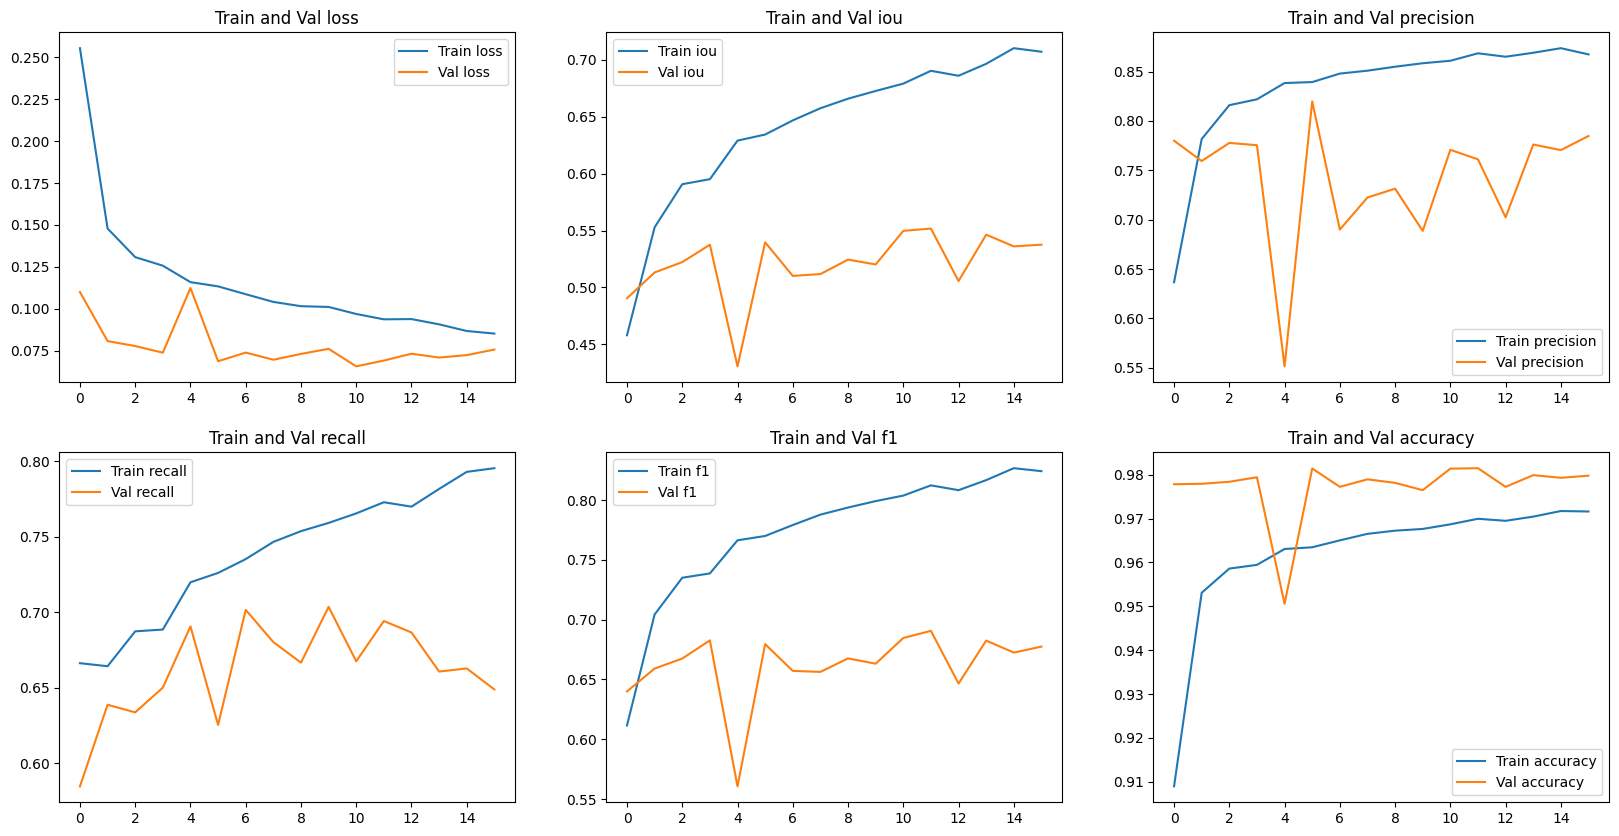

In [23]:
# plot the training and validation metrics
# plot train and val in same plot

def plot_metrics(result_dict):
    metrics = ['loss', 'iou', 'precision', 'recall', 'f1', 'accuracy']

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))

    for i, metric in enumerate(metrics):
        ax = axes[i // 3, i % 3]

        ax.plot(result_dict[f'train_{metric}'], label=f'Train {metric}')
        ax.plot(result_dict[f'val_{metric}'], label=f'Val {metric}')

        ax.set_title(f'Train and Val {metric}')
        ax.legend()

    plt.show()

plot_metrics(result_dict)

## 4.2. Predict Test Dataset

In [24]:
from tqdm import tqdm
progress_bar = None
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

def test_step(model, test_loader, loss_fn):
    global progress_bar

    progress_bar = tqdm(total=len(test_loader), desc="Testing", leave=False)
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).squeeze(1)
        loss = loss_fn(outputs, labels.float())
        iou, precision, recall, f1, accuracy = calculate_metrics(outputs, labels)

        progress_bar.update(1)
        progress_bar.set_postfix({"Loss": loss.item(), "IoU": iou.item(), "F1": f1.item()})

    progress_bar.close()

    return loss.item(), iou.item(), precision.item(), recall.item(), f1.item(), accuracy.item()

def test(model, test_loader, loss_fn):
    global progress_bar

    test_loss, test_iou, test_precision, test_recall, test_f1, test_accuracy = test_step(model, test_loader, loss_fn)

    print(f"Test Loss: {test_loss:.5f} | Test IoU: {test_iou:.5f} | Test Precision: {test_precision:.5f} | Test Recall: {test_recall:.5f} | Test F1: {test_f1:.5f} | Test Accuracy: {test_accuracy:.5f}")

In [25]:
test(best_model, test_loader, loss_fn)

Test Loss: 0.03149 | Test IoU: 0.41259 | Test Precision: 0.76623 | Test Recall: 0.47200 | Test F1: 0.58416 | Test Accuracy: 0.99487


## 4.3. Visualize Test Predictions

In [26]:
def visualize_segmentation(image, mask, prediction):
    plt.figure(figsize=(12, 12))

    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(0), cmap='gray')
    plt.axis('off')
    plt.title('Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Prediction')

    plt.show()

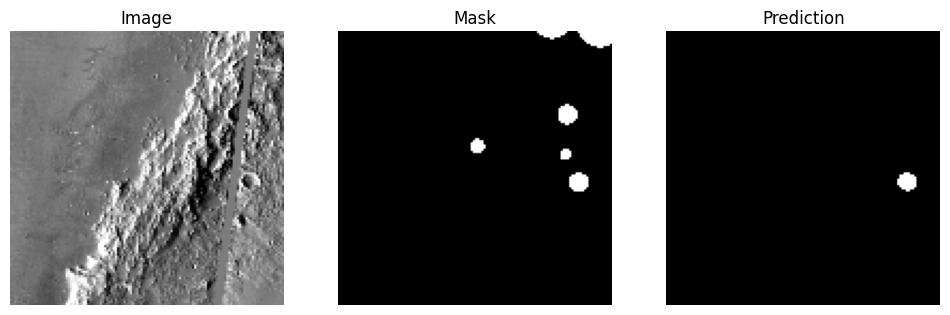

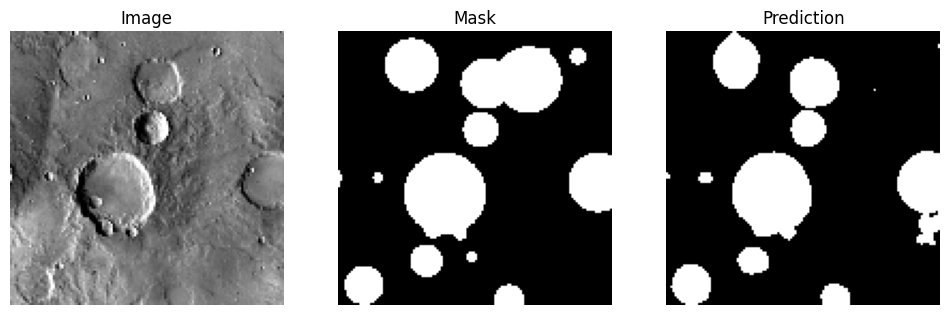

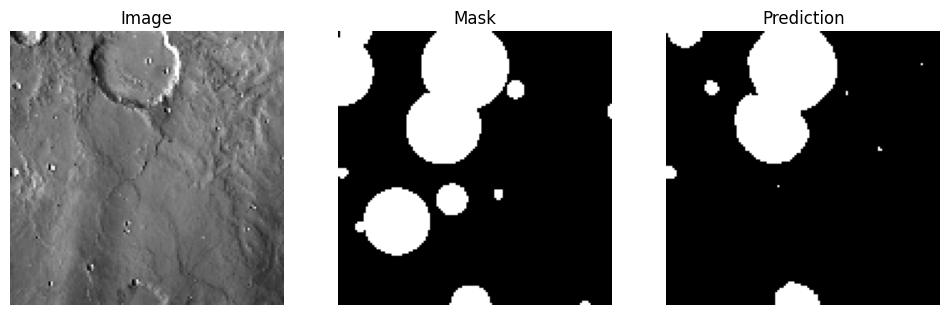

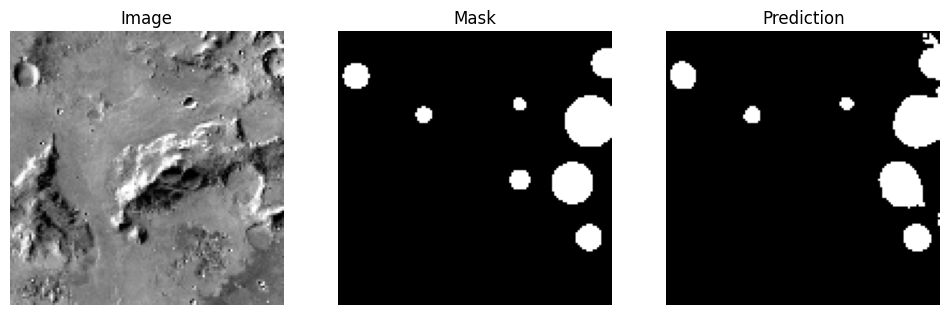

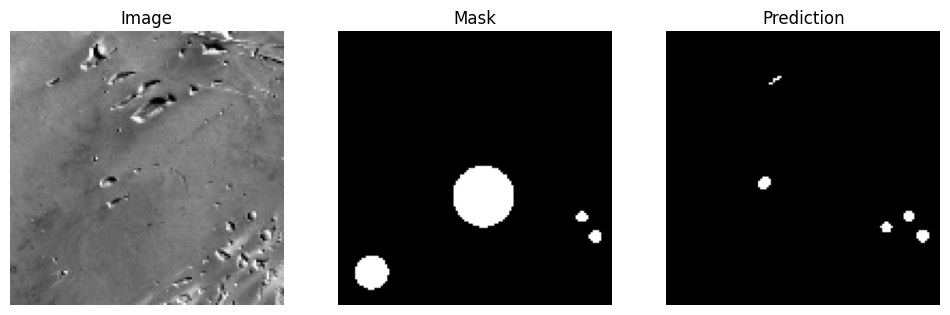

In [27]:
for i in range(5):
    random_idx = np.random.randint(0, len(test_dataset))
    image, mask = test_dataset[random_idx]
    image = image.unsqueeze(0).to(device)
    mask = mask.unsqueeze(0).to(device)

    prediction = best_model(image).squeeze(0).detach().cpu().numpy() > 0.4

    visualize_segmentation(image.cpu(), mask.cpu(), prediction)

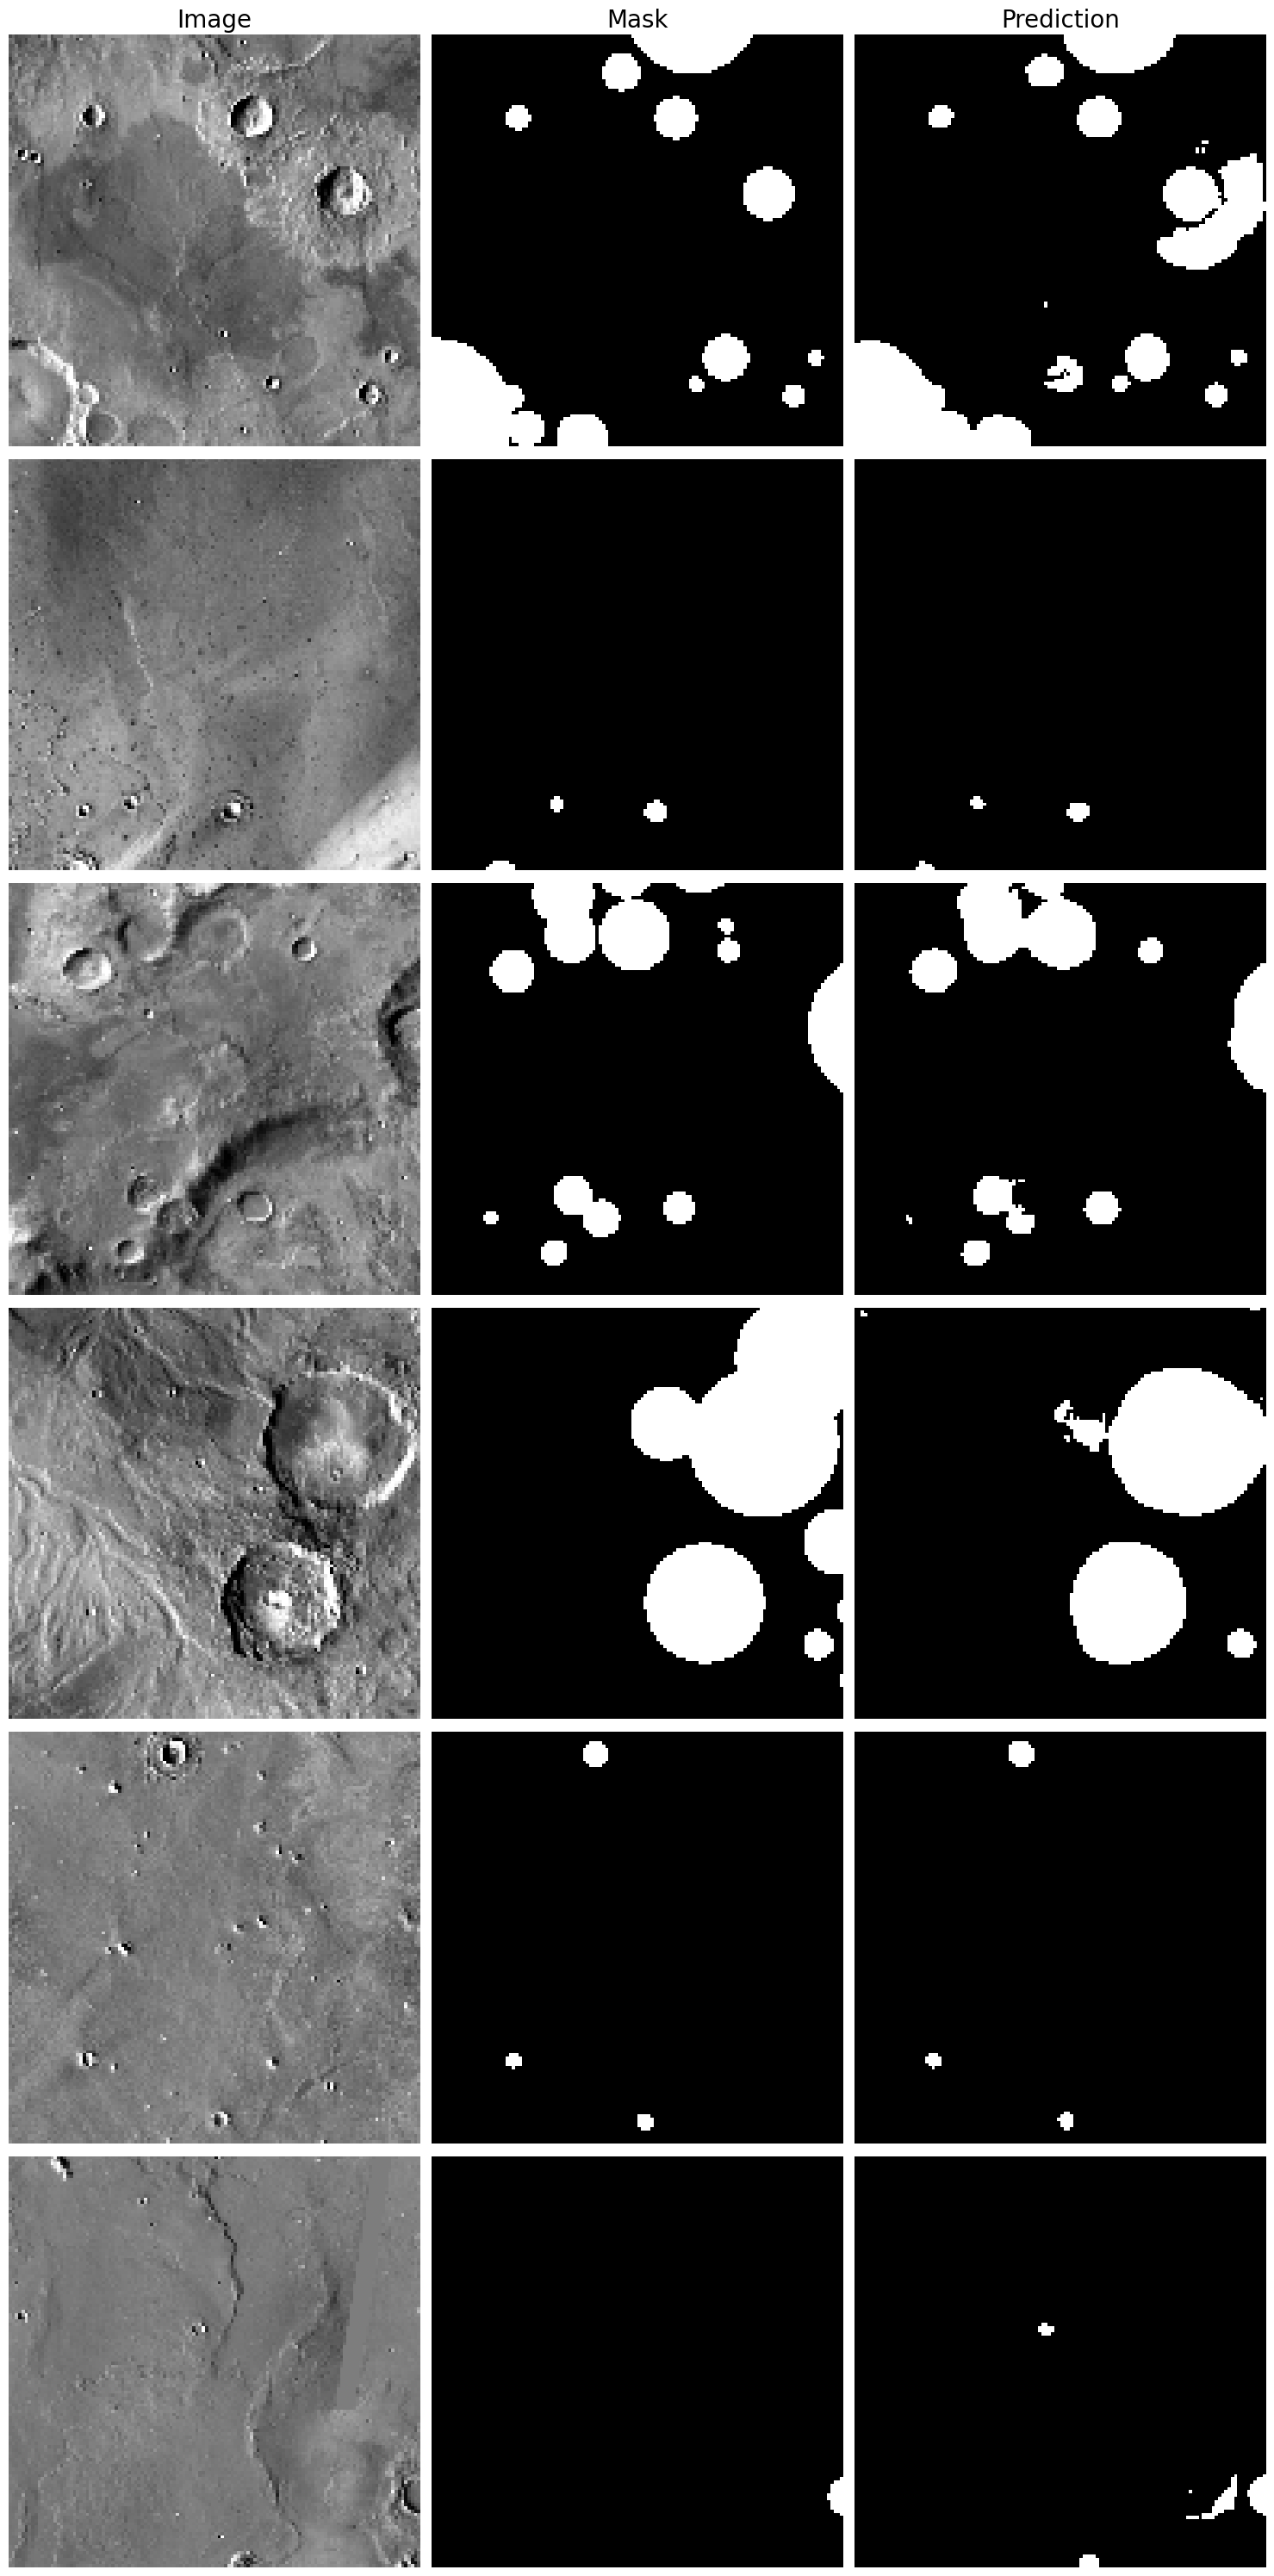

In [36]:
def visualize_predictions(num_images, test_dataset, model):
    """
    Visualize a given number of random images, their masks, and model predictions.
    
    Args:
    - num_images (int): Number of images to visualize.
    - test_dataset: Dataset containing image-mask pairs.
    - model: Trained model to generate predictions.
    """
    plt.figure(figsize=(15, num_images * 5))

    for i in range(num_images):
        random_idx = np.random.randint(0, len(test_dataset))
        image, mask = test_dataset[random_idx]
        image = image.unsqueeze(0).to(device)
        mask = mask.unsqueeze(0).to(device)

        prediction = model(image).squeeze(0).detach().cpu().numpy() > 0.4

        # Plot the original image
        plt.subplot(num_images, 3, 3*i + 1)
        plt.imshow(image.cpu().squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Image', fontsize=20)

        # Plot the ground truth mask
        plt.subplot(num_images, 3, 3*i + 2)
        plt.imshow(mask.cpu().squeeze(0), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Mask', fontsize=20)

        # Plot the prediction
        plt.subplot(num_images, 3, 3*i + 3)
        plt.imshow(prediction.squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Prediction', fontsize=20)

    plt.tight_layout()
    plt.show()

visualize_predictions(6, test_dataset, best_model)